In [1]:
# LIBRARIES FOR NOTEBOOK
import xarray as xr

In [2]:
#LBRARIES FOR FUNCTIONS
import os
import numpy as np
import geopandas as gpd

from rasterio.features import shapes
from shapely.geometry import Polygon

import cv2
# pip install opencv-python-headless
# https://pypi.org/project/opencv-python/

## FUNCTIONS

In [3]:
# EXTRACT POLYGONS FROM REGIONS
# we are reusing the functions previoysly coded in temp_increase_regions.ipynb notebook @ Aurora server

# ------------------------------------------------------------------

# shape is a single JSON-ish polygon coming from the rasterio.features.shapes function
# rasterio.features.shapes returns a list of pairs (shape, value), example of a pair:
#   ({'type': 'Polygon', 'coordinates': [[(6,0),(6,2),(8,0),(6,0)]]}, 1.0)
#   shape is the first entry (the dictionary)
def create_polygon(shape):
    
    poly_list = shape.get('coordinates')

    if len(poly_list) == 1:    # polygon without holes
        return Polygon(poly_list[0])

    holes = []
    for i in range(1,len(poly_list)):
        holes.append(poly_list[i])
    return Polygon(shell=poly_list[0], holes=holes)

# ------------------------------------------------------------------
# ------------------------------------------------------------------

# shapes_list is the output from rasterio.features.shapes (type generator, iterable once)
# crs that will be assigned to the GeoDataFrame
def shapes_2_GeoDataFrame(shapes_list, crs = False):

    df = gpd.GeoDataFrame() 
    i = 0
    for shape, value in shapes_list:
        df.loc[i,'geometry'] = create_polygon(shape)
        i = i+1

    if(crs != False):
        df.crs = crs
    
    return df

# ------------------------------------------------------------------
# ------------------------------------------------------------------
def thick_regions(regions, iterations=1):
    
    aff = regions.rio.transform()
    crs = regions.rio.crs
    
    np_rgns = regions.to_numpy()
    thick_regions = cv2.dilate(np_rgns, 
               np.ones((3,3), np.uint8), 
               iterations)
    thick_regions = thick_regions.astype('uint8')  
    
    thick_shps = shapes(source = thick_regions, 
                     mask= thick_regions,   # include this so regions with value 0 are not inclduded
                     connectivity = 8,
                     transform = aff)

    return shapes_2_GeoDataFrame(thick_shps , crs)

# ------------------------------------------------------------------
# ------------------------------------------------------------------

def export_regions(regions,file_name,parent_dir):
    
    new_dir = parent_dir + file_name
    outfp = os.path.join(new_dir, file_name+'.shp')

    os.mkdir(new_dir)
    regions.to_file(outfp)
    return

## TRIALS - CLIMATE DATA

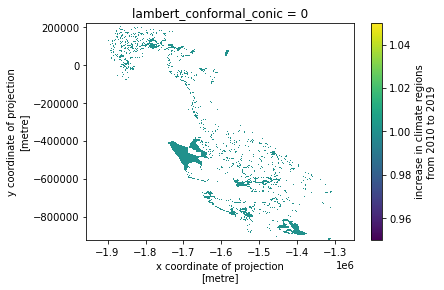

In [5]:
path = "/home/jovyan/PlanetComp_climate_layer/clim_increase_10_19.nc"
clim_rgns = xr.open_dataarray(path)
clim_rgns.plot()

In [6]:
clim_polygons = thick_regions(clim_rgns)
clim_polygons

,geometry
0,"POLYGON ((-1861750.000 210500.000, -1861750.00..."
1,"POLYGON ((-1859750.000 210500.000, -1859750.00..."
2,"POLYGON ((-1869750.000 209500.000, -1869750.00..."
3,"POLYGON ((-1845750.000 209500.000, -1845750.00..."
4,"POLYGON ((-1843750.000 207500.000, -1843750.00..."
...,...
2784,"POLYGON ((-1458750.000 -901500.000, -1458750.0..."
2785,"POLYGON ((-1456750.000 -903500.000, -1456750.0..."
2786,"POLYGON ((-1453750.000 -907500.000, -1453750.0..."
2787,"POLYGON ((-1309750.000 -910500.000, -1305750.0..."


In [7]:
# ----- SAVE RESULTS -----
# file_name = "clim_increase_10_19"
# parent_dir = "/home/jovyan/PlanetComp_climate_layer/"

# export_regions(clim_polygons,file_name,parent_dir)

## TRIALS - ARIDITY DATA

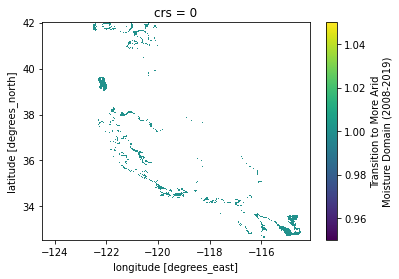

In [8]:
outfp = "/home/jovyan/PlanetComp_aridity_layer/arid_increase_19_08.nc"
aridity_regions = xr.open_dataarray(outfp)
aridity_regions.plot()

In [9]:
arid_polygons = thick_regions(aridity_regions)
arid_polygons

,geometry
0,"POLYGON ((-122.16250 42.00417, -121.87083 42.0..."
1,"POLYGON ((-121.74583 41.87917, -121.74583 41.8..."
2,"POLYGON ((-121.28750 41.87917, -121.28750 41.8..."
3,"POLYGON ((-120.20417 41.87917, -120.20417 41.7..."
4,"POLYGON ((-122.49583 42.00417, -122.45417 42.0..."
...,...
205,"POLYGON ((-115.87083 32.92083, -115.87083 32.8..."
206,"POLYGON ((-115.28750 32.92083, -115.28750 32.8..."
207,"POLYGON ((-115.41250 33.29583, -115.37083 33.2..."
208,"POLYGON ((-116.03750 32.79583, -116.03750 32.7..."


In [10]:
# ----- SAVE RESULTS -----
# file_name = "arid_increase_08_19"
# parent_dir = "/home/jovyan/PlanetComp_aridity_layer/"

# export_regions(arid_polygons,file_name,parent_dir)